# Explore signal/price movement relationship

This is an example notebook to explore whether a trading signal results to profitable trades.

- It explores a small set of pairs on Uni v3 on Polygon
- Both long and short are considered (though shorts might be theoretical only, if such a lending market doest not exist in the point of time)

In [59]:
import datetime

import pandas as pd

from tradingstrategy.client import Client
from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.utils.default_strategies import get_default_strategies_path
from tradeexecutor.strategy.execution_context import notebook_execution_context
from tradeexecutor.utils.default_strategies import get_default_strategies_path
from tradeexecutor.strategy.strategy_module import read_strategy_module
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data, load_trading_and_lending_data
from tradeexecutor.strategy.universe_model import UniverseOptions


pair_list = [
    [ChainId.polygon, "quickswap", "WETH", "USDC"],
    [ChainId.polygon, "quickswap", "LINK", "WETH"],
    [ChainId.polygon, "quickswap", "WMATIC", "USDC"],
    [ChainId.polygon, "quickswap", "WBTC", "USDC"],
    [ChainId.polygon, "quickswap", "SAND", "WMATIC"],
]


def create_trading_universe(
    ts: datetime.datetime,
    client: Client,
    execution_context,
    universe_options,
) -> TradingStrategyUniverse:
    
    dataset = load_partial_data(
        client,
        execution_context=execution_context,
        universe_options=universe_options,
        # Ask for all Polygon data
        pairs=pair_list,
        time_bucket=TimeBucket.d1,
    )

    universe = TradingStrategyUniverse.create_from_dataset(dataset, reserve_asset_desc="0x2791bca1f2de4661ed88a30c99a7a9449aa84174")

    return universe


client = Client.create_jupyter_client()

strategy_universe = create_trading_universe(
    datetime.datetime.utcnow(),
    client,
    notebook_execution_context,
    # Uniswap v3 gets deployed around 2022-07-07
    UniverseOptions(start_at=pd.Timestamp("2022-01-01"), end_at=pd.Timestamp("2023-11-01")),
)

data_universe = strategy_universe.data_universe

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


### Interactive viewer mode

Set Plotly chart output mode to interactive viewing.

In [60]:
from tradeexecutor.utils.notebook import OutputMode, setup_charting_and_output

setup_charting_and_output(OutputMode.interactive, image_format="svg", max_rows=35)
#setup_charting_and_output(
#    OutputMode.static, 
#    image_format="png",
#    width=1500,
#    height=1200,    
#)

## Explore signal vs price change

Create a function `calculate_signal_vs_profit` which calculates 
- Signal (naive momentum)
- Profit: the last and the best future price we can get
- Allows us to play around with different time windows
- Split between shorts and longs


In [61]:
import humanize

# Set up parameters of time windows
# we use for this notebook run
momentum_window = pd.Timedelta(days=1)
ma_short = 14
ma_long = 21
profit_window = pd.Timedelta(days=1)


# Use later in chart titles
signal_window_label = humanize.naturaldelta(momentum_window)
profit_window_label = humanize.naturaldelta(profit_window)


Create a function `calculate_signal_vs_price_for_pair` which calculates 
- Calculates the signal vs. for certain trading pair
- Bundle few different pairs to the same `DataFrame` so we can examine them together


In [62]:
from typing import List
import numpy as np
from pandas.tseries.frequencies import to_offset
from pandas_ta import ema

from tradingstrategy.utils.forward_fill import forward_fill
from tradingstrategy.pair import DEXPair


def calculate_signal_vs_profit(
    df: pd.DataFrame, 
    momentum_window: pd.Timedelta, 
    profit_window: pd.Timedelta,
    data_time_bucket: pd.Timedelta,        
) -> pd.DataFrame:
    """Calculate signals and profits for all incoming candles."""
    
    # Create entries for past price to be used for signal
    # and future price (used for the price correlation)
    momentum_offset = to_offset(momentum_window)
    profit_offset = to_offset(profit_window)

    df["prev"] = df["open"].shift(freq=momentum_offset)
    df["next"] = df["open"].shift(freq=-profit_offset)

    # What is our predicted price
    df["price_diff"] = (df["next"] - df["open"]) / df["open"]  # Get the profit on the final day of profit window

    # Calculate signal from the past and price difference to the future
    df["momentum"] = (df["prev"] - df["open"]) / df["open"]
    
    df["ma_long"] = ema(df["open"], length=ma_long) 
    df["ma_short"] = ema(df["open"], length=ma_short)
    
    df["ma_diff"] = (df["open"] - df["ma_short"]) / df["open"]

    df["bullish"] = df["ma_diff"] >= 0
    df["bearish"] = df["ma_diff"] < 0

    df["signal"] = 0
    df.loc[df["bullish"] & (df["momentum"] >= 0), "signal"] = df["momentum"]
    df.loc[df["bearish"] & (df["momentum"] < 0), "signal"] = df["momentum"]
    df["signal"] = df["momentum"]

    # On negative signals, we go short.
    # On zero signal and lack of data set side to NA
    df["side"] = pd.NA
    
    df.loc[df["signal"] > 0, "side"] = "long"
    df.loc[df["signal"] < 0, "side"] = "short"

    number_of_candles = profit_window / data_time_bucket
    assert number_of_candles > 0 and number_of_candles.is_integer(), f"Could not calculate candle count that fits into profit window {profit_window} for data time frame {data_time_bucket}"
    number_of_candles = int(number_of_candles)

    # Max and min price wihtin the profit window will determine the profit for longs and shorts respective
    df["max_future_price"] = df["close"].rolling(number_of_candles).max().shift(-number_of_candles) # Get the max profit on the profit window, assuming take profit %
    df["min_future_price"] = df["close"].rolling(number_of_candles).min().shift(-number_of_candles) # Get the max profit on the profit window, assuming take profit %    
    
    # Calculate profit separately for longs and shorts
    # using Pandas Mask
    # https://stackoverflow.com/a/33770421/315168
    #
    # We calculate both profit after X time,
    # and also max take profit, assuming
    # we could do a perfect trailing stop loss
    #
    longs = (df["side"] == "long")
    shorts = (df["side"] == "short")
    df.loc[longs, "profit"] = df["price_diff"]
    df.loc[shorts, "profit"] = -df["price_diff"]
    df.loc[longs, "profit_max"] = (df["max_future_price"] - df["open"]) / df["open"]  # Get the profit based on max price
    df.loc[shorts, "profit_max"] = -(df["min_future_price"] - df["open"]) / df["open"]  # Get the profit based on max price

    df.loc[longs, "desc"] = df.agg('{0[pair]} long'.format, axis=1)
    df.loc[shorts, "desc"] = df.agg('{0[pair]} short'.format, axis=1)
    
    return df


def calculate_signal_vs_price_for_pair(
    pair: DEXPair
) -> pd.DataFrame:
    """Calculate signal vs. profit ratio for an individual pair."""
    df = data_universe.candles.get_candles_by_pair(pair)
    assert df is not None

    df = df.copy()

    # Make sure there are no gaps in the data
    df = forward_fill(
        df, 
        freq=data_universe.time_bucket.to_frequency(), 
        columns=("open", "high", "low", "close")
    )

    df["pair"] = pair.get_ticker()
    df = calculate_signal_vs_profit(
        df,
        momentum_window,
        profit_window,
        data_time_bucket=data_universe.time_bucket.to_pandas_timedelta(),
    )

    return df

# Pull out trading pair details for pairs we are examining
examined_pairs: List[DEXPair]
examined_pairs = [data_universe.pairs.get_pair_by_human_description(p) for p in pair_list]

# Show what pairs we are examining
print("Examined pairs:")
examined_pairs_df = pd.DataFrame([p.to_dict() for p in examined_pairs])
display(examined_pairs_df[["exchange_slug", "base_token_symbol", "quote_token_symbol", "fee"]].style.hide(axis="index").set_properties(**{'text-align': 'left'}))

pair_dfs = [calculate_signal_vs_price_for_pair(pair) for pair in examined_pairs]
df = pd.concat(pair_dfs)
pd.set_option('display.min_rows', 36)
print(f"Example price data, we have total {len(df):,} candles")
display(df)

Examined pairs:


exchange_slug,base_token_symbol,quote_token_symbol,fee
quickswap,WETH,USDC,30
quickswap,LINK,WETH,30
quickswap,WMATIC,USDC,30
quickswap,WBTC,USDC,30
quickswap,SAND,WMATIC,30


Example price data, we have total 3,350 candles


,open,high,low,close,pair,prev,next,price_diff,momentum,ma_long,...,ma_diff,bullish,bearish,signal,side,max_future_price,min_future_price,profit,profit_max,desc
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-01,3685.288207,3787.845027,3682.032735,3761.470924,WETH-USDC,NaN,3761.467727,0.020671,NaN,NaN,...,NaN,False,False,NaN,<NA>,3825.436519,3825.436519,NaN,NaN,NaN
2022-01-02,3761.467727,3839.370147,3729.533679,3825.436519,WETH-USDC,3685.288207,3825.422534,0.017003,-0.020253,NaN,...,NaN,False,False,-0.020253,short,3762.704674,3762.704674,-0.017003,-0.000329,WETH-USDC short
2022-01-03,3825.422534,3835.795922,3682.045654,3762.704674,WETH-USDC,3761.467727,3762.703879,-0.016395,-0.016718,NaN,...,NaN,False,False,-0.016718,short,3793.188319,3793.188319,0.016395,0.008426,WETH-USDC short
2022-01-04,3762.703879,3883.253812,3721.987381,3793.188319,WETH-USDC,3825.422534,3792.128363,0.007820,0.016669,NaN,...,NaN,False,False,0.016669,long,3548.044807,3548.044807,0.007820,-0.057049,WETH-USDC long
2022-01-05,3792.128363,3835.024346,3204.987672,3548.044807,WETH-USDC,3762.703879,3547.886565,-0.064408,-0.007759,NaN,...,NaN,False,False,-0.007759,short,3416.130030,3416.130030,0.064408,0.099152,WETH-USDC short
2022-01-06,3547.886565,3547.886565,3184.831886,3416.130030,WETH-USDC,3792.128363,3416.129362,-0.037137,0.068841,NaN,...,NaN,False,False,0.068841,long,3186.759510,3186.759510,-0.037137,-0.101787,WETH-USDC long
2022-01-07,3416.129362,3416.129362,3003.808231,3186.759510,WETH-USDC,3547.886565,3187.555700,-0.066910,0.038569,NaN,...,NaN,False,False,0.038569,long,3088.833621,3088.833621,-0.066910,-0.095809,WETH-USDC long
2022-01-08,3187.555700,3240.457393,2900.073742,3088.833621,WETH-USDC,3416.129362,3088.858725,-0.030963,0.071708,NaN,...,NaN,False,False,0.071708,long,3157.802925,3157.802925,-0.030963,-0.009334,WETH-USDC long
2022-01-09,3088.858725,3211.868842,3066.767226,3157.802925,WETH-USDC,3187.555700,3157.787411,0.022315,0.031953,NaN,...,NaN,False,False,0.031953,long,3074.473137,3074.473137,0.022315,-0.004657,WETH-USDC long


# Example trading pair chart

Plot with our indicators



In [63]:
from tradingstrategy.charting.candle_chart import visualise_ohlcv

import plotly.graph_objects as go

# Pick single pair to examine
# The first pair is ETH-USD
single_df = pair_dfs[0]

# display(eth_usd_df)

fig = visualise_ohlcv(
    single_df,
    num_detached_indicators=3,
    subplot_names=["Price", "Signal", "Momentum", "MA diff"],
)

fig.add_trace(
    go.Scatter(name="MA long", x=single_df.index, y=single_df["ma_long"]),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(name="MA short", x=single_df.index, y=single_df["ma_short"]),
    row=1,
    col=1,
)


fig.add_trace(
    go.Scatter(name="Signal", x=single_df.index, y=single_df["signal"]),
    row=2,
    col=1,
)

fig.add_trace(
    go.Scatter(name="Momentum", x=single_df.index, y=single_df["momentum"]),
    row=3,
    col=1,
)

fig.add_trace(
    go.Scatter(name="MA diff", x=single_df.index, y=single_df["ma_diff"]),
    row=4,
    col=1,
)

fig.show()

display(single_df)

,open,high,low,close,pair,prev,next,price_diff,momentum,ma_long,...,ma_diff,bullish,bearish,signal,side,max_future_price,min_future_price,profit,profit_max,desc
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-01,3685.288207,3787.845027,3682.032735,3761.470924,WETH-USDC,NaN,3761.467727,0.020671,NaN,NaN,...,NaN,False,False,NaN,<NA>,3825.436519,3825.436519,NaN,NaN,NaN
2022-01-02,3761.467727,3839.370147,3729.533679,3825.436519,WETH-USDC,3685.288207,3825.422534,0.017003,-0.020253,NaN,...,NaN,False,False,-0.020253,short,3762.704674,3762.704674,-0.017003,-0.000329,WETH-USDC short
2022-01-03,3825.422534,3835.795922,3682.045654,3762.704674,WETH-USDC,3761.467727,3762.703879,-0.016395,-0.016718,NaN,...,NaN,False,False,-0.016718,short,3793.188319,3793.188319,0.016395,0.008426,WETH-USDC short
2022-01-04,3762.703879,3883.253812,3721.987381,3793.188319,WETH-USDC,3825.422534,3792.128363,0.007820,0.016669,NaN,...,NaN,False,False,0.016669,long,3548.044807,3548.044807,0.007820,-0.057049,WETH-USDC long
2022-01-05,3792.128363,3835.024346,3204.987672,3548.044807,WETH-USDC,3762.703879,3547.886565,-0.064408,-0.007759,NaN,...,NaN,False,False,-0.007759,short,3416.130030,3416.130030,0.064408,0.099152,WETH-USDC short
2022-01-06,3547.886565,3547.886565,3184.831886,3416.130030,WETH-USDC,3792.128363,3416.129362,-0.037137,0.068841,NaN,...,NaN,False,False,0.068841,long,3186.759510,3186.759510,-0.037137,-0.101787,WETH-USDC long
2022-01-07,3416.129362,3416.129362,3003.808231,3186.759510,WETH-USDC,3547.886565,3187.555700,-0.066910,0.038569,NaN,...,NaN,False,False,0.038569,long,3088.833621,3088.833621,-0.066910,-0.095809,WETH-USDC long
2022-01-08,3187.555700,3240.457393,2900.073742,3088.833621,WETH-USDC,3416.129362,3088.858725,-0.030963,0.071708,NaN,...,NaN,False,False,0.071708,long,3157.802925,3157.802925,-0.030963,-0.009334,WETH-USDC long
2022-01-09,3088.858725,3211.868842,3066.767226,3157.802925,WETH-USDC,3187.555700,3157.787411,0.022315,0.031953,NaN,...,NaN,False,False,0.031953,long,3074.473137,3074.473137,0.022315,-0.004657,WETH-USDC long


## Plot signal vs. price samples

Different scatter charts to examine if there is a correlation between the signal and the profit.

In [64]:
import plotly.express as px

fig = px.scatter(
    df, 
    x="signal", 
    y="profit_max", 
    trendline="ols", 
    color="desc", 
    title=f"Max potential take profit, signal {signal_window_label}, profit window {profit_window_label}",
    #marginal_x="histogram", 
    #marginal_y="rug"
)
fig.update_layout(legend=dict(title='Pair and direction'))
fig.show()

fig = px.scatter(
    df, 
    x="signal", 
    y="profit", 
    trendline="ols", 
    color="desc", 
    title=f"Profit last day, signal {signal_window_label}, profit window {profit_window_label}",
    #marginal_x="histogram", 
    #marginal_y="rug"    
)
fig.update_layout(legend=dict(title='Pair and direction'))
fig.show()

### Long only vs. short 

Examine trade types separately to better see if one side is clearly superior.

In [65]:
df_long_only = df.loc[df["side"] == "long"]

fig = px.scatter(
    df_long_only, 
    x="signal", 
    y="profit_max", 
    trendline="ols", 
    color="desc", 
    title=f"Long only max take profit, signal {signal_window_label}, profit window {profit_window_label}",

)
fig.show()

fig = px.scatter(
    df_long_only, 
    x="signal", 
    y="profit", 
    trendline="ols", 
    color="desc", 
    title=f"Long only profit last day, signal {signal_window_label}, profit window {profit_window_label}"
)
fig.show()

fig = px.scatter(
    df_long_only, 
    x="signal", 
    y="profit_max", 
    trendline="ols", 
    trendline_color_override="black", 
    title=f"Long only max take profit, signal {signal_window_label}, profit window {profit_window_label}"
)
fig.show()

fig = px.scatter(
    df_long_only, 
    x="signal", 
    y="profit", 
    trendline="ols", 
    trendline_color_override="black", 
    title=f"Long only last profit, signal {signal_window_label}, profit window {profit_window_label}"
)
fig.show()



In [66]:
df_short_only = df.loc[df["side"] == "short"]

fig = px.scatter(
    df_short_only, 
    x="signal", 
    y="profit_max", 
    trendline="ols", 
    color="desc", 
    title=f"Short only max take profit, signal {signal_window_label}, profit window {profit_window_label}"
)
fig.show()

fig = px.scatter(
    df_short_only, 
    x="signal", 
    y="profit", 
    trendline="ols", 
    color="desc", 
    title=f"Short only profit last day, signal {signal_window_label}, profit window {profit_window_label}"
)
fig.show()

### Filtered signal

Remove low signals below a certain threshold and see if it affects the correlation between the signal and the profit.

In [67]:

threshold = 0.075

filtered_df = df_long_only.loc[abs(df_long_only["signal"]) >= threshold]

fig = px.scatter(
    filtered_df, 
    x="signal", 
    y="profit_max", 
    trendline="ols", 
    trendline_color_override="black", 
    title=f"Long-only filtered the signal at {threshold}, max take profit, signal {signal_window_label}, profit window {profit_window_label}"
)
fig.show()

fig = px.scatter(
    filtered_df, 
    x="signal", 
    y="profit", 
    trendline="ols", 
    trendline_color_override="black", 
    title=f"Long-only filtered the signal at {threshold}, profit last day, signal {signal_window_label}, profit window {profit_window_label}")
fig.show()

fig = px.scatter(
    df_long_only, 
    x="signal", 
    y="profit", 
    trendline="ols", 
    trendline_color_override="black", 
    title=f"No filter, profit last day, signal {signal_window_label}, profit window {profit_window_label}")
fig.show()

filtered_df = df_short_only.loc[abs(df_short_only["signal"]) >= threshold]

fig = px.scatter(
    filtered_df, 
    x="signal", 
    y="profit_max", 
    trendline="ols", 
    trendline_color_override="black", 
    title=f"Short only filtered the signal at {threshold}, max take profit, signal {signal_window_label}, profit window {profit_window_label}"
)
fig.show()

fig = px.scatter(
    filtered_df, 
    x="signal", 
    y="profit", 
    trendline="ols", 
    trendline_color_override="black", 
    title=f"Short only filtered the signal at {threshold}, profit last day, signal {signal_window_label}, profit window {profit_window_label}")
fig.show()

## Heatmap

Invidual point cloud is hard to interpret, so render it as a heatmap instead.

In [68]:

clipped_df = df.loc[abs(df["signal"]) < 0.2]

fig = px.density_heatmap(
    clipped_df, 
    x="signal", 
    y="profit", 
    nbinsx=50, 
    title="Signal vs. profit"

)
fig.show()

#weth = df.loc[df["pair"] == "WETH-UDSC long"]
#fig = px.density_heatmap(df, x="signal", y="profit_max", nbinsx=30, title="WETH")
#fig.show()

## Hexbin plot

Try to make more sense from the point cloud.

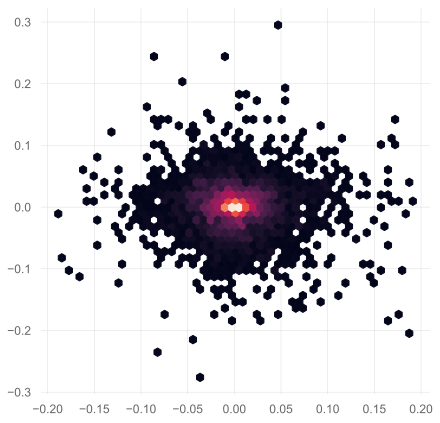

In [69]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#import cmocean#  http://matplotlib.org/cmocean/

plt.figure(figsize=(7, 7))
ax = plt.hexbin(clipped_df["signal"], clipped_df["profit"], gridsize=50, mincnt=1) # cmocean.cm.algae is a cmocean colormap
# plt.set_title("Signal vs. Price matches")
plt.show()
# display(df)